In [127]:
import keras
keras.__version__

'2.2.0'

In [128]:
import csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer

csvFile = '/Users/aleksey/Main/MachineLearning/moving-classification/gyroscope_data.csv'
numberOfMeasurementsPerSample = 50


csvFileReader = csv.reader(open(csvFile), delimiter=',')
linesWithoutHeader = ([x for x in csvFileReader])[1:]

def removeLastColumn(lines):
    return [line[:-1] for line in lines]

def prepareDictionaryWithLabelsToSortedMeasurements(lines):
    def filterLinesWithLabel(label, lines):
        return [line for line in lines if line[-1] == label]

    def sortByTime(lines):
        return sorted(lines, key=lambda line: line[-2], reverse=False)
    
    def findUniqLabes(lines):
        return set([line[-1] for line in lines])
    
    labesToFeatures = {}
    
    for label in findUniqLabes(lines):
        labesToFeatures[label] = removeLastColumn(filterLinesWithLabel(label, lines))
    
    return labesToFeatures

labelsToMeasurements = prepareDictionaryWithLabelsToSortedMeasurements(linesWithoutHeader)                                                   

def prepareData(labelsToMeasurements, numberOfMeasurementsPerSample):
    def createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample):
        numberOfSamples = len(measurements) // numberOfMeasurementsPerSample
        
        samples = np.zeros((numberOfSamples, numberOfMeasurementsPerSample, len(measurements[0])))
        
        for i in range(0, numberOfSamples):
            measurementsPerSample = measurements[i * numberOfMeasurementsPerSample : (i + 1) * numberOfMeasurementsPerSample]
            samples[i] = np.array(measurementsPerSample)
        return samples
    
    samples = []
    targets = []
    
    for label, measurements in labelsToMeasurements.items():
        samplesOfLabel = createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample)
        
        samples.extend(samplesOfLabel)
        targets.extend(np.full((samplesOfLabel.shape[0]), label))
    
    return np.array(samples), np.array(targets)

def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = prepareData(labelsToMeasurements, numberOfMeasurementsPerSample)
samples, targets = shuffleSamplesAndTargets(samples, targets)
targets = LabelBinarizer().fit_transform(targets)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [129]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [159]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [160]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [161]:
history = model.fit(train_data,
                    train_labels,
                    epochs=350,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/350
756/756 [==============================] - 3s 4ms/step - loss: 0.4073 - acc: 0.3624 - val_loss: 0.2864 - val_acc: 0.5516
Epoch 2/350
756/756 [==============================] - 0s 135us/step - loss: 0.3858 - acc: 0.3889 - val_loss: 0.2799 - val_acc: 0.5595
Epoch 3/350
756/756 [==============================] - 0s 127us/step - loss: 0.3656 - acc: 0.4246 - val_loss: 0.2847 - val_acc: 0.5635
Epoch 4/350
756/756 [==============================] - 0s 121us/step - loss: 0.3701 - acc: 0.4167 - val_loss: 0.2833 - val_acc: 0.5595
Epoch 5/350
756/756 [==============================] - 0s 123us/step - loss: 0.3497 - acc: 0.4484 - val_loss: 0.2756 - val_acc: 0.5754
Epoch 6/350
756/756 [==============================] - 0s 165us/step - loss: 0.3412 - acc: 0.4603 - val_loss: 0.2579 - val_acc: 0.6032
Epoch 7/350
756/756 [==============================] - 0s 120us/step - loss: 0.3333 - acc: 0.4749 - val_loss: 0.2591 - val_acc: 0.5992
Epoch 8/350

Epoch 61/350
756/756 [==============================] - 0s 143us/step - loss: 0.1409 - acc: 0.7540 - val_loss: 0.0950 - val_acc: 0.8452
Epoch 62/350
756/756 [==============================] - 0s 133us/step - loss: 0.1366 - acc: 0.7579 - val_loss: 0.0950 - val_acc: 0.8254
Epoch 63/350
756/756 [==============================] - 0s 136us/step - loss: 0.1467 - acc: 0.7302 - val_loss: 0.1049 - val_acc: 0.8016
Epoch 64/350
756/756 [==============================] - 0s 124us/step - loss: 0.1289 - acc: 0.7685 - val_loss: 0.0937 - val_acc: 0.8135
Epoch 65/350
756/756 [==============================] - 0s 141us/step - loss: 0.1261 - acc: 0.7725 - val_loss: 0.0905 - val_acc: 0.8214
Epoch 66/350
756/756 [==============================] - 0s 121us/step - loss: 0.1294 - acc: 0.7487 - val_loss: 0.0968 - val_acc: 0.8135
Epoch 67/350
756/756 [==============================] - 0s 133us/step - loss: 0.1310 - acc: 0.7526 - val_loss: 0.0737 - val_acc: 0.8571
Epoch 68/350
756/756 [==========================

756/756 [==============================] - 0s 146us/step - loss: 0.0609 - acc: 0.8743 - val_loss: 0.0379 - val_acc: 0.9325
Epoch 122/350
756/756 [==============================] - 0s 170us/step - loss: 0.0515 - acc: 0.9008 - val_loss: 0.0405 - val_acc: 0.9444
Epoch 123/350
756/756 [==============================] - 0s 152us/step - loss: 0.0576 - acc: 0.8810 - val_loss: 0.0405 - val_acc: 0.9246
Epoch 124/350
756/756 [==============================] - 0s 136us/step - loss: 0.0548 - acc: 0.8995 - val_loss: 0.0398 - val_acc: 0.9286
Epoch 125/350
756/756 [==============================] - 0s 128us/step - loss: 0.0598 - acc: 0.8849 - val_loss: 0.0379 - val_acc: 0.9286
Epoch 126/350
756/756 [==============================] - 0s 135us/step - loss: 0.0582 - acc: 0.8902 - val_loss: 0.0422 - val_acc: 0.9246
Epoch 127/350
756/756 [==============================] - 0s 144us/step - loss: 0.0501 - acc: 0.9101 - val_loss: 0.0423 - val_acc: 0.9087
Epoch 128/350
756/756 [==============================] 

Epoch 181/350
756/756 [==============================] - 0s 163us/step - loss: 0.0332 - acc: 0.9365 - val_loss: 0.0283 - val_acc: 0.9484
Epoch 182/350
756/756 [==============================] - 0s 174us/step - loss: 0.0380 - acc: 0.9246 - val_loss: 0.0301 - val_acc: 0.9524
Epoch 183/350
756/756 [==============================] - 0s 147us/step - loss: 0.0385 - acc: 0.9286 - val_loss: 0.0276 - val_acc: 0.9524
Epoch 184/350
756/756 [==============================] - 0s 121us/step - loss: 0.0353 - acc: 0.9405 - val_loss: 0.0284 - val_acc: 0.9484
Epoch 185/350
756/756 [==============================] - 0s 134us/step - loss: 0.0352 - acc: 0.9418 - val_loss: 0.0272 - val_acc: 0.9484
Epoch 186/350
756/756 [==============================] - 0s 143us/step - loss: 0.0380 - acc: 0.9246 - val_loss: 0.0280 - val_acc: 0.9484
Epoch 187/350
756/756 [==============================] - 0s 128us/step - loss: 0.0329 - acc: 0.9405 - val_loss: 0.0343 - val_acc: 0.9444
Epoch 188/350
756/756 [==================

Epoch 241/350
756/756 [==============================] - 0s 140us/step - loss: 0.0207 - acc: 0.9643 - val_loss: 0.0235 - val_acc: 0.9603
Epoch 242/350
756/756 [==============================] - 0s 136us/step - loss: 0.0247 - acc: 0.9563 - val_loss: 0.0239 - val_acc: 0.9643
Epoch 243/350
756/756 [==============================] - 0s 142us/step - loss: 0.0262 - acc: 0.9524 - val_loss: 0.0236 - val_acc: 0.9563
Epoch 244/350
756/756 [==============================] - 0s 147us/step - loss: 0.0247 - acc: 0.9471 - val_loss: 0.0233 - val_acc: 0.9603
Epoch 245/350
756/756 [==============================] - 0s 133us/step - loss: 0.0262 - acc: 0.9524 - val_loss: 0.0242 - val_acc: 0.9603
Epoch 246/350
756/756 [==============================] - 0s 147us/step - loss: 0.0244 - acc: 0.9537 - val_loss: 0.0231 - val_acc: 0.9603
Epoch 247/350
756/756 [==============================] - 0s 142us/step - loss: 0.0206 - acc: 0.9709 - val_loss: 0.0253 - val_acc: 0.9563
Epoch 248/350
756/756 [==================

Epoch 301/350
756/756 [==============================] - 0s 140us/step - loss: 0.0285 - acc: 0.9431 - val_loss: 0.0233 - val_acc: 0.9603
Epoch 302/350
756/756 [==============================] - 0s 147us/step - loss: 0.0209 - acc: 0.9577 - val_loss: 0.0208 - val_acc: 0.9683
Epoch 303/350
756/756 [==============================] - 0s 127us/step - loss: 0.0203 - acc: 0.9643 - val_loss: 0.0200 - val_acc: 0.9683
Epoch 304/350
756/756 [==============================] - 0s 132us/step - loss: 0.0217 - acc: 0.9616 - val_loss: 0.0199 - val_acc: 0.9683
Epoch 305/350
756/756 [==============================] - 0s 139us/step - loss: 0.0208 - acc: 0.9630 - val_loss: 0.0227 - val_acc: 0.9643
Epoch 306/350
756/756 [==============================] - 0s 134us/step - loss: 0.0190 - acc: 0.9683 - val_loss: 0.0189 - val_acc: 0.9683
Epoch 307/350
756/756 [==============================] - 0s 128us/step - loss: 0.0193 - acc: 0.9656 - val_loss: 0.0229 - val_acc: 0.9603
Epoch 308/350
756/756 [==================

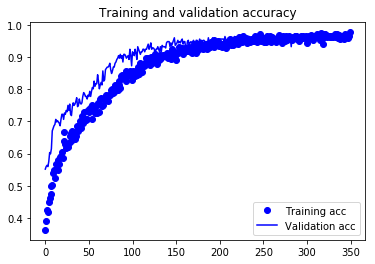

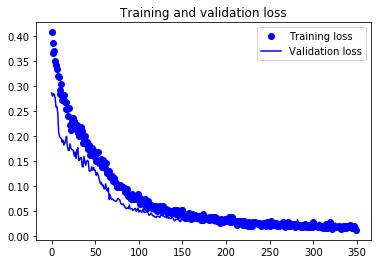

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [163]:
model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 44us/step


[0.014652975837677894, 0.9761904780826871]

In [ ]:
model.predict(test_data[0:1])